# S4D what has happend so far

In [6]:
# S4D recurrent mode implemented in ucode with and without SigmaDeltaEncoding
# S4D trained directly with torch (with and without quantization aware training from torch module)
# Sigma S4D Delta trained with Slayer

In [7]:
import os
from lava.utils.system import Loihi2
loihi2_is_available = Loihi2.is_loihi2_available
if loihi2_is_available:
    # Enable SLURM, the workload manager used to distribute Loihi2 resources to users
    os.environ['SLURM'] = '1'
    os.environ['PARTITION'] = "kp"
    os.environ['LOIHI_GEN'] = "N3B3"
import numpy as np
from lava.proc.sdn.process import SigmaDelta, Sigma
from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter
import matplotlib.pyplot as plt
from src.lava.lib.dl.slayer.state_space_models.s4 import S4D
import torch
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg, Loihi2SimCfg
from lava.proc.dense.process import Dense
from lava.proc.sdn.process import ActivationMode
from lava.proc.s4d.process import SigmaS4dDelta, S4d
from lava.proc.sparse.process import Sparse
from lava.proc.spike_integrator.process import SpikeIntegrator
import random
random.seed(12)
np.random.seed(12)
torch.manual_seed(12)
# S4d
# state = state * A + inp * B
# outp = state * C                                           
# outp += inp * D
# Check relu
# Onchip S4_exp

## Pure untrained comparison with random matrix weights 
- quantizing S4D vs not quantizing S4D
- using Sigma-Delta wrapping vs. not using Sigma-Delta wrapping
- torch outputs are always obtained in convolution mode, lava outputs are always obtained in step mode


In [8]:
model_dim = 10
d_states = 64
random.seed(12)
np.random.seed(12)
torch.manual_seed(12)
model_quantized = S4D(d_model=model_dim,
            d_state=d_states,
            dropout=False,
            transposed=True,
            quantize=True,
            lr=None,
            skip=False,
            activation=None,
            is_real=True)
random.seed(12)
np.random.seed(12)
torch.manual_seed(12)
model = S4D(d_model=model_dim,
            d_state=d_states,
            dropout=False,
            transposed=True,
            quantize = False,
            lr=None,
            skip=False,
            activation=None,
            is_real=True)

model.setup_step()
model_quantized.setup_step()

n_steps = 1000 # sequence length
inp_exp = 10
inp = (torch.rand(1, model_dim, n_steps) * 2** inp_exp).int().float()



def example_run(inp, on_chip, use_sd, quantize):
    # Test just sigma-delta on chip
    n_steps = 1000
    state_exp = 6
    numpy_inp = np.asarray(inp)[0]

    if not quantize:
        A = model.layer.kernel.dA.detach().numpy()
        B = model.layer.kernel.dB.detach().numpy()
        C = model.layer.kernel.dC.detach().numpy()
    else:
        A = model_quantized.layer.kernel.dA.detach().numpy()
        B = model_quantized.layer.kernel.dB.detach().numpy()
        C = model_quantized.layer.kernel.dC.detach().numpy()
    if use_sd:
        diff_inp = numpy_inp[:, 1:] - numpy_inp[:, :-1]
        numpy_inp = np.concatenate((numpy_inp[:, :1], diff_inp), axis=1)

    kron_matrix = np.kron(np.eye(model_dim), np.ones((d_states, )))

    spiker = SourceBuffer(data=numpy_inp)
    adapter_i = PyToNxAdapter(shape=(model_dim, ), num_message_bits=24)
   
    if not use_sd:
        dense_1 = Sparse(weights=kron_matrix.T, weight_exp=6, num_message_bits=24)
        neuron = S4d(shape=((model_dim * d_states,)), s4_exp = 12,               # hard coded to shift by 6!!!
                            a=A.flatten().reshape((model_dim * d_states,)),
                            b=B.flatten().reshape((model_dim * d_states,)),
                            c=C.flatten().reshape((model_dim * d_states,)))
        relay = SpikeIntegrator(shape=(model_dim,), q_scale=1/2**6, q_exp=6)
        dense_2 = Sparse(weights=kron_matrix, num_message_bits=24, weight_exp=6)
    else:
        dense_1 = Sparse(weights=kron_matrix.T, weight_exp=6, num_message_bits=24)
        neuron = SigmaS4dDelta(shape=((model_dim * d_states,)), vth=0, state_exp=6, s4_exp = 12,
                            a=A.flatten().reshape((model_dim * d_states,)),
                            b=B.flatten().reshape((model_dim * d_states,)),
                            c=C.flatten().reshape((model_dim * d_states,)))
        relay = SigmaDelta(shape=(model_dim,), vth=0, state_exp=6, act_mode=ActivationMode.UNIT, num_message_bits=24)
        dense_2 = Sparse(weights=kron_matrix, num_message_bits=24, weight_exp=6)
  
    adapter_o = NxToPyAdapter(shape=(model_dim,), num_message_bits=24)
    receiver = SinkBuffer(buffer=n_steps, shape=(model_dim,))

    # Connected input -> Dense -> Delta -> neuron -> Dense -> Sigma -> Dense -> Output
    if on_chip:
        spiker.s_out.connect(adapter_i.inp)
        adapter_i.out.connect(dense_1.s_in)
        dense_1.a_out.connect(neuron.a_in)
        neuron.s_out.connect(dense_2.s_in)
        dense_2.a_out.connect(relay.a_in)  
        relay.s_out.connect(adapter_o.inp) 
        adapter_o.out.connect(receiver.a_in)
        run_cfg = Loihi2HwCfg()
        n_steps = n_steps
    else:
        spiker.s_out.connect(dense_1.s_in)
        dense_1.a_out.connect(neuron.a_in)
        neuron.s_out.connect(dense_2.s_in)
        dense_2.a_out.connect(receiver.a_in)
        run_cfg = Loihi2SimCfg()
        n_steps = n_steps
    
    neuron.run(
                condition=RunSteps(num_steps=n_steps), run_cfg=run_cfg
            )
    received_data_hw = receiver.data.get()
    if on_chip:
            received_data_hw = ((received_data_hw.astype(np.int32) << 8) >> 8).T
    else:
        received_data_hw = received_data_hw.T
    neuron.stop()
    
    if use_sd:
        received_data_hw= np.cumsum(received_data_hw, axis=0)
         
    return received_data_hw

In [9]:
out = model(inp)[0].detach().numpy().T
out_quantized = model_quantized(inp)[0].detach().numpy().T

#sim_no_sd = example_run(inp, on_chip=False, use_sd=False, quantize=False)
#sim_sd = example_run(inp, on_chip=False, use_sd=True, quantize=False)
#hw_no_sd = example_run(inp, on_chip=True, use_sd=False, quantize=False)
#hw_sd = example_run(inp, on_chip=True, use_sd=True, quantize=False)

#sim_no_sd_q = example_run(inp, on_chip=False, use_sd=False, quantize=True)
#sim_sd_q = example_run(inp, on_chip=False, use_sd=True, quantize=True)
#hw_no_sd_q = example_run(inp, on_chip=True, use_sd=False, quantize=True)
#hw_sd_q = example_run(inp, on_chip=True, use_sd=True, quantize=True)


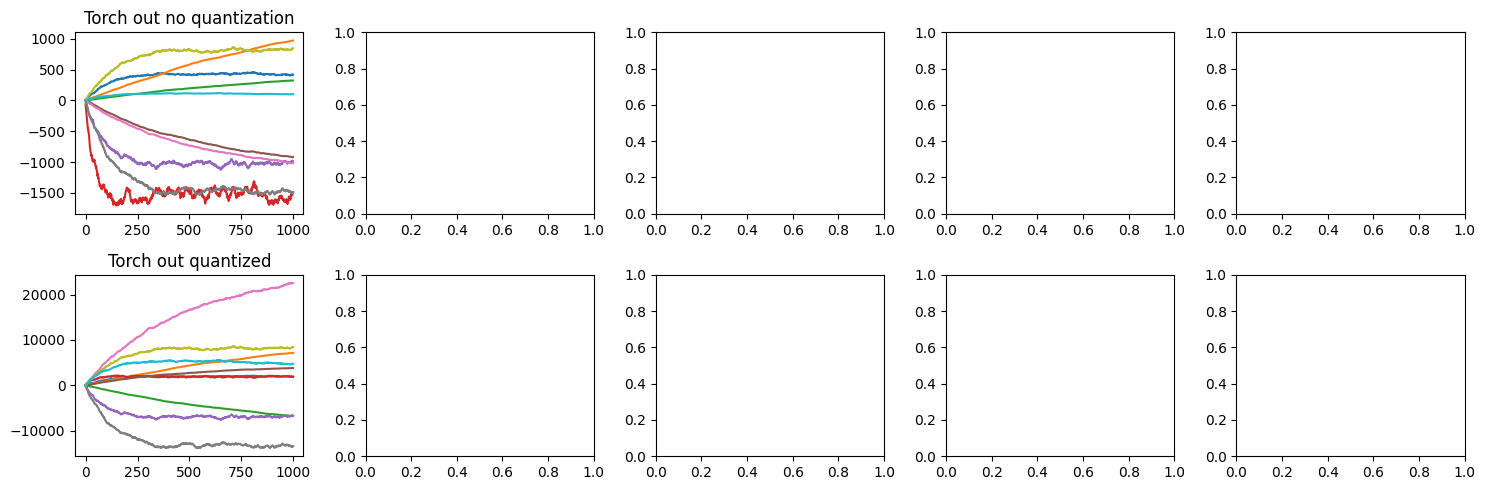

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(15, 5))
# quantization sim sim-sigma-delta hw hw-sigma-delta
# no quantization sim sim-sigma-delta hw hw-sigma-delta

axs[0][0].plot(out)
axs[0][0].set_title("Torch out no quantization")
#axs[0][1].plot(sim_no_sd)
#axs[0][1].set_title("S4D Sim")
#axs[0][2].plot(hw_no_sd)
#axs[0][2].set_title("S4D loihi")
#axs[0][3].plot(sim_sd)
#axs[0][3].set_title("Sigma-S4D-Delta Sim")
#axs[0][4].plot(hw_sd)
#axs[0][4].set_title("Sigma-S4D-Delta loihi")
axs[1][0].plot(out_quantized)
axs[1][0].set_title("Torch out quantized")
#axs[1][1].plot(sim_no_sd_q)
#axs[1][1].set_title("S4D Sim - quantized")
#axs[1][2].plot(hw_no_sd_q)
#axs[1][2].set_title("S4D loihi - quantized")
#axs[1][3].plot(sim_sd_q)
#axs[1][3].set_title("Sigma-S4D-Delta Sim - quantized")
#axs[1][4].plot(hw_sd_q)
#axs[1][4].set_title("Sigma-S4D-Delta loihi - quantized")
#tight layout
plt.tight_layout()


# Training Attempts

- Trained on sCIFAR
- Always trained with Convolutional mode (in the beginning even non-quantized)
- One layer: Input -> Encoder -> S4D -> FF -> Decoder


### 1) Training with Slayer and Sigma-S4D-Delta - not using quantization yet!
- results: 30% accuracy during training dropped to 16% when transferred to chip
- With random weights it didn't look too bad though


-----------------------------------------------------------------------------------
### Changes
- Use only four hidden states
- Train for only 10 epochs to reduce iteration times 

### 2) Training S4D with torch, quantized S4D, and quantization aware training
- training-script: train_without_lava_dl.py
- validation-script: s4d_validation.ipynb
- Result: 37% accuracy off chip, 33% accuracy on chip - highly depends on (input) exponents...

### 3) Training again with Slayer and Sigma-S4D-Delta this time with quantization
- Network: network.py
- Training: train_S4D.py
- Validation:  validate_scifar_trained_with_slayer.ipynb
- Result: 29% accuracy off chip, 19% on chip (with inp_exp=12); 23% on chip (with inp_exp=14), inp_exp=15 leads to overflows

### Ideas why simulation is worse in slayer compared to torch: 
- Apparently used different model size
- Also need to check learning rates and optimizer

------------------------------------------------------------------------------------
### WIP 
### 4) Training with just torch, quantized S4D and no quantization aware training
- Training: train_without_lava_dl.py # uncommented torch quantization stuff
- Validation: s4d_validation.ipynb 
- Result: 

### 5) Training directly based on step-wise (reccurent mode) or fine tuning on step-wise mode
- So far extremly slow :(

# to-do
- quantization aware training unclear

meeting 5/13
- accelerate reccurent mode (direct cuda (fastest) vs. triton (easier to get started))
- monitor overflows -> change exponents


1) train vanilla s4d
2) quantized reccurent
3) Sigma-Delta encapsulation 
- do everything step by step 

